#  Starter Notebook on Forecasting Inflation

## Navigation
I. <b>Import Libraries and Data Loading</b><br>
a) [Import Libraries and Data Loading](#libraries)<br><br>

II. <b> Data Understanding</b><br>
a) [Macroeconomic Trends](#trend)<br>
b) [Core CPI trend by Month and Quarter](#mq)<br><br>

III. <b> Forecast</b><br>
a) [ARIMA](#arima)<br>
b) [Univariate Forecasting with LSTM](#ulstm)<br>
c) [Multivariate Forecasting with LSTM](#mlstm)<br>


##  Import Libraries and Data Loading
<a id="libraries"></a>

In [316]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import datetime
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

np.random.seed(234)
tf.random.set_seed(234)

In [317]:
print(tf.__version__)

2.6.2


In [318]:
monthly_raw = pd.read_csv('../input/usa-key-macroeconomic-indicators/macro_monthly.csv',parse_dates=True)
monthly_raw.shape

(490, 12)

Lets take from 1994 onwards, as there are some NaNs for some of the indicators.
We can do so by simply dropping the NaNs.

In [319]:
monthly_raw.dropna(inplace=True)
monthly_raw.head(5)

,DATE,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
156,1994-01-01,6.6,7.1,3481.800,7363.1,4585.1,105.21,5.750500,3.050645,513314.0,67.0596,154.5
157,1994-02-01,6.6,6.5,3459.675,7377.2,4632.6,104.66,5.973158,3.245000,513196.0,67.1060,154.8
158,1994-03-01,6.5,6.8,3476.975,7401.7,4646.0,104.78,6.482609,3.335806,521040.0,67.7792,155.3
159,1994-04-01,6.4,6.4,3507.150,7402.0,4671.1,104.68,6.972105,3.555000,528063.0,68.1906,155.5
160,1994-05-01,6.1,7.6,3472.840,7487.4,4669.5,103.78,7.183333,4.010968,532328.0,68.5136,155.9


## Data Understanding
Quick check on data types and convert realtime_start and date to datetime.

In [320]:
monthly_raw.dtypes

monthly_raw.DATE = pd.to_datetime(monthly_raw.DATE)

DATE       object
unrate    float64
psr       float64
m2        float64
dspic     float64
pce       float64
reer      float64
ir        float64
ffer      float64
tcs       float64
indpro    float64
ccpi      float64
dtype: object

Check number of month/year in dataset

In [321]:
monthly_raw['DATE'].nunique()

334

Create a copy

In [322]:
monthly_df = monthly_raw.copy()

### Macroeconomic Indicator Trend
<a id = "trend"></a>
We can perform feature generation first and create percentage change Month-over-month and Year-over-year.

array([[<AxesSubplot:title={'center':'Unemployment Rate'}>,
        <AxesSubplot:title={'center':'Personal Saving Rate'}>,
        <AxesSubplot:title={'center':'M2'}>],
       [<AxesSubplot:title={'center':'Disposable Income'}>,
        <AxesSubplot:title={'center':'Personal Consumption Expenditure'}>,
        <AxesSubplot:title={'center':'Real Effective Exchange Rate'}>],
       [<AxesSubplot:title={'center':'10Y Treasury Yield'}>,
        <AxesSubplot:title={'center':'Fed Rate'}>,
        <AxesSubplot:title={'center':'Construction Spending'}>],
       [<AxesSubplot:title={'center':'Industrial Production Index'}>,
        <AxesSubplot:title={'center':'Core CPI'}>,
        <AxesSubplot:title={'center':'Core CPI % Change MoM'}>]],
      dtype=object)

Text(0.5, 0.98, '27 Year Macroeconomic Indicators for the United States')

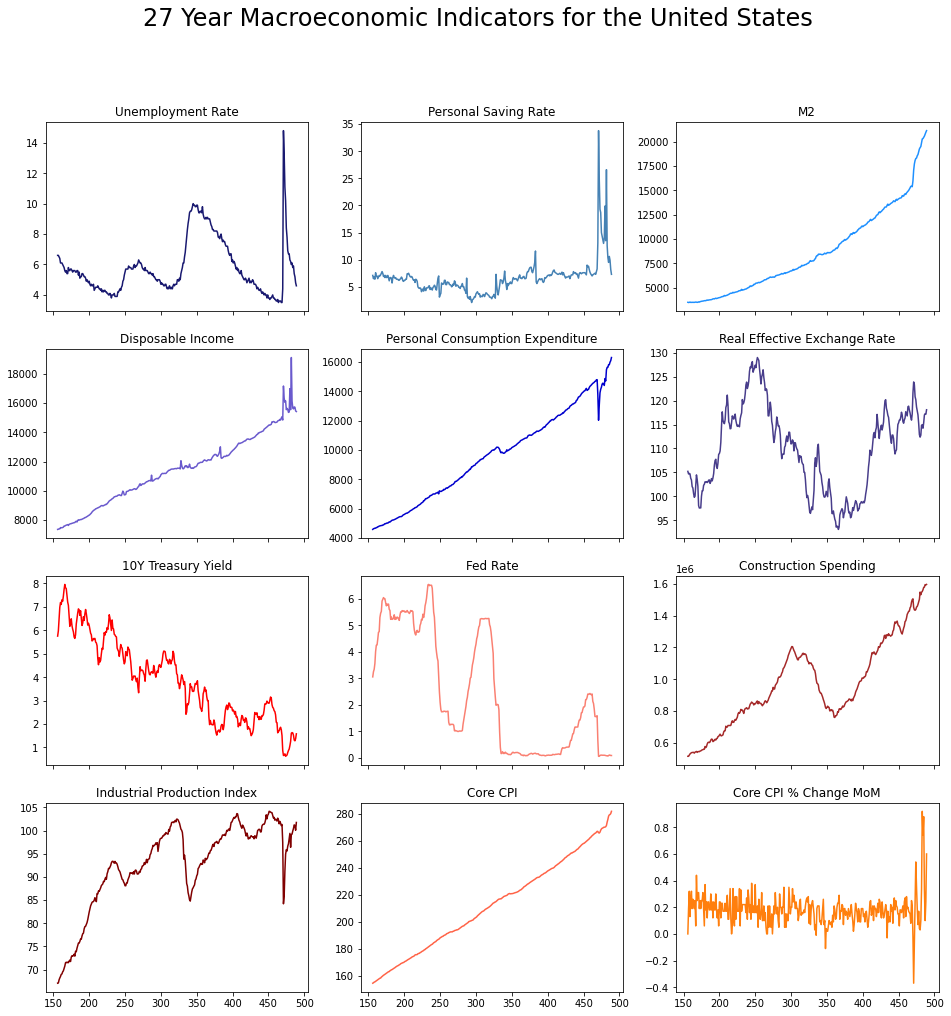

In [323]:
monthly_df['cpi_pct_mom'] = round((monthly_df['ccpi'].pct_change().fillna(0))*100,2)
monthly_df['cpi_pct_yoy'] = round((monthly_df['ccpi'].pct_change(12).fillna(0))*100,2)

monthly_df.iloc[:, 1:13].plot(kind ='line',
            subplots = True,
            figsize = (16,16),
            title = ['Unemployment Rate', 'Personal Saving Rate','M2','Disposable Income','Personal Consumption Expenditure','Real Effective Exchange Rate',
                     '10Y Treasury Yield','Fed Rate','Construction Spending','Industrial Production Index','Core CPI','Core CPI % Change MoM'],
            legend = False,
            layout = (4,3),
            sharex = True,
            style = ['midnightblue', 'steelblue', 'dodgerblue', 'slateblue','mediumblue','darkslateblue','red','salmon','brown','maroon','tomato'])

plt.suptitle('27 Year Macroeconomic Indicators for the United States', fontsize = 24)

### Core CPI trend by Month and Quarter
<a id = "mq"></a>

In [324]:
monthly_df['year'] = monthly_df['DATE'].apply(lambda x: x.year)
monthly_df['quarter'] = monthly_df['DATE'].apply(lambda x: x.quarter)
monthly_df['month'] = monthly_df['DATE'].apply(lambda x: x.month)

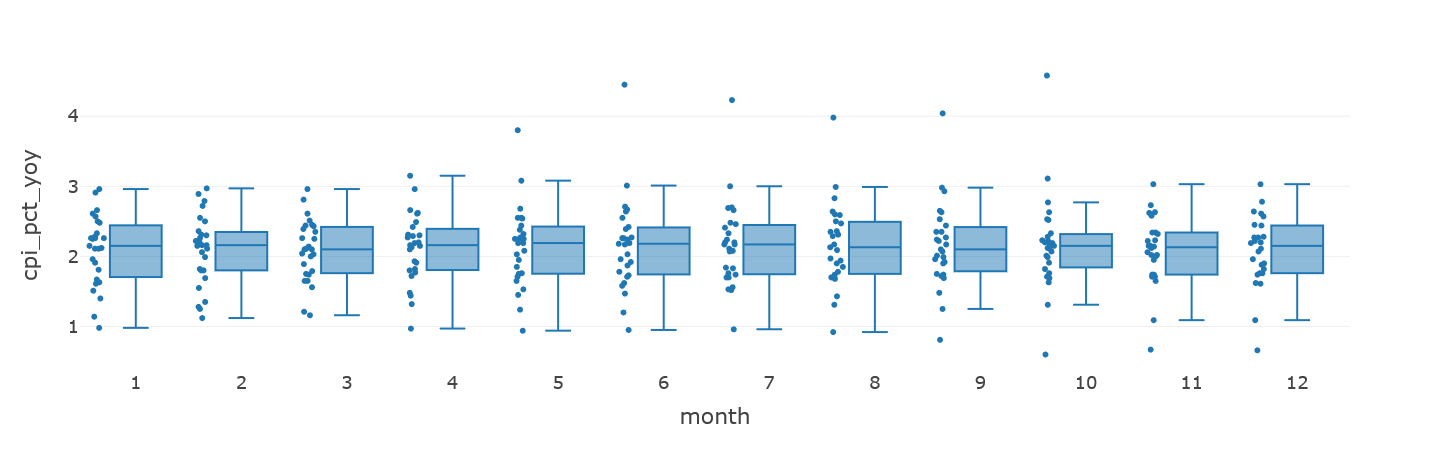

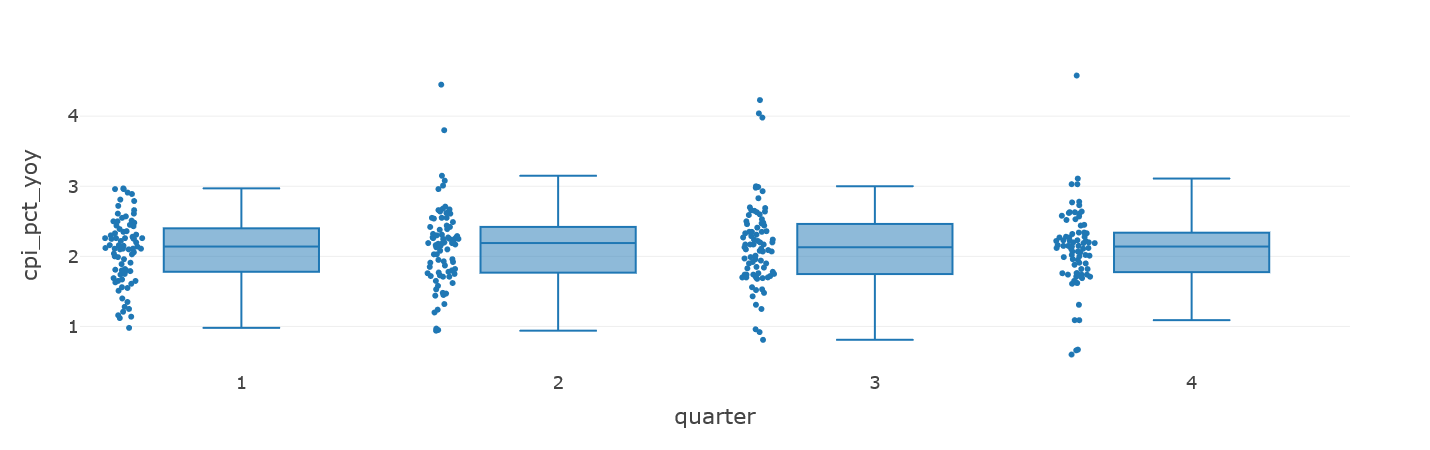

In [325]:
fig = px.box(monthly_df[12:], x="month", y="cpi_pct_yoy", points = "all", template = "presentation",)
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',))

fig = px.box(monthly_df[12:], x="quarter", y="cpi_pct_yoy", points = "all", template = "presentation")

fig.show()

Looking at the Core CPI change in an annualized basis, we can see that the earlier parts of the year showed more significant increases in Core CPI. While in the last few months, there are more outliers (below the lower whiskers) meaning that they showed little change from the previous year.<br> We can further explore the volatility of the change in Core CPI YoY.

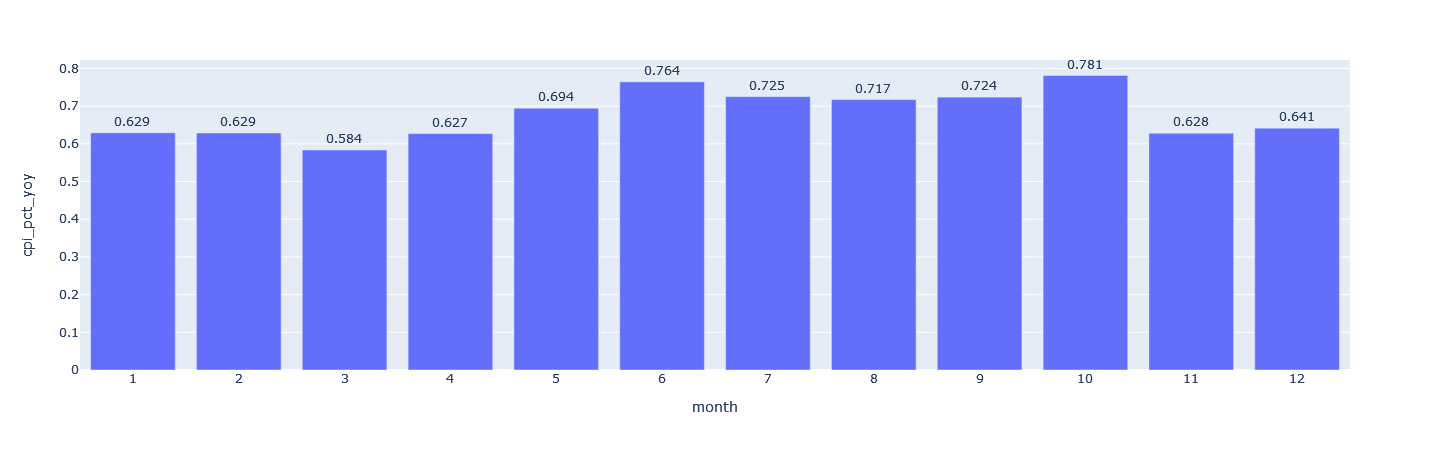

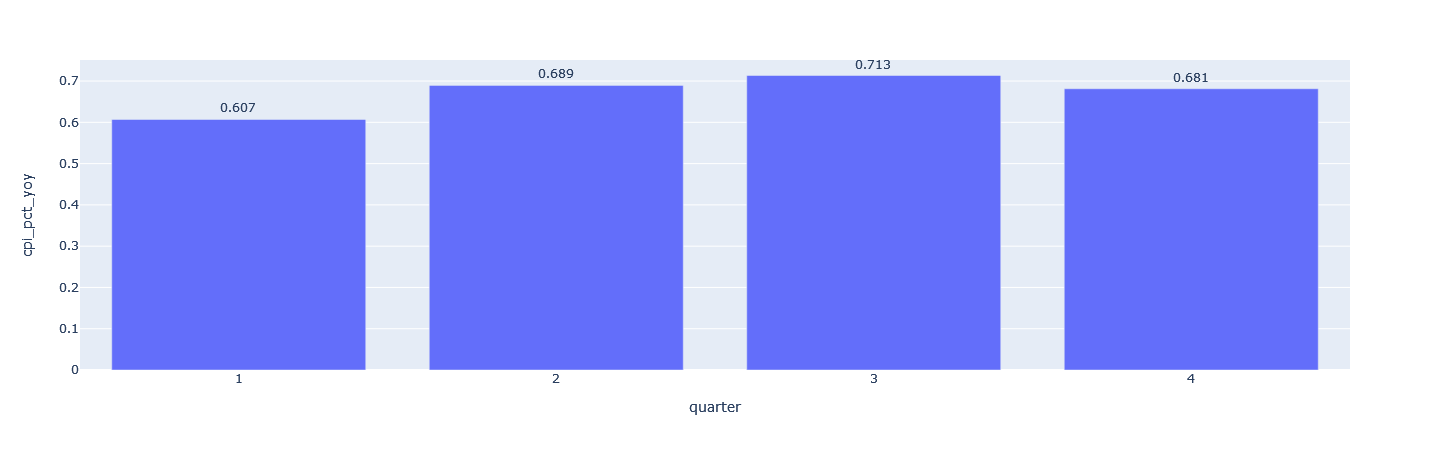

In [326]:
fig = px.bar(
    data_frame=monthly_df.groupby(['month']).std().reset_index(), 
    x="month", 
    y="cpi_pct_yoy", text="cpi_pct_yoy"
).update_traces(texttemplate='%{text:0.3f}', textposition='outside').update_xaxes(nticks=13)
fig.show()

fig = px.bar(
    data_frame=monthly_df.groupby(['quarter']).std().reset_index(), 
    x="quarter", 
    y="cpi_pct_yoy", text="cpi_pct_yoy").update_traces(texttemplate='%{text:0.3f}', textposition='outside').update_xaxes(nticks=5)
fig.show()

## Forecasting Inflation

In [327]:
monthly_raw.shape
monthly_raw.head(5)

(334, 12)

,DATE,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
156,1994-01-01,6.6,7.1,3481.800,7363.1,4585.1,105.21,5.750500,3.050645,513314.0,67.0596,154.5
157,1994-02-01,6.6,6.5,3459.675,7377.2,4632.6,104.66,5.973158,3.245000,513196.0,67.1060,154.8
158,1994-03-01,6.5,6.8,3476.975,7401.7,4646.0,104.78,6.482609,3.335806,521040.0,67.7792,155.3
159,1994-04-01,6.4,6.4,3507.150,7402.0,4671.1,104.68,6.972105,3.555000,528063.0,68.1906,155.5
160,1994-05-01,6.1,7.6,3472.840,7487.4,4669.5,103.78,7.183333,4.010968,532328.0,68.5136,155.9


Set date as the dataframe's index.

In [328]:
df_cpi = monthly_raw.set_index('DATE')

## ARIMA Implementation
<a id = "arima"></a>
As the problem is a time-series forecasting, Autoregressive Integrated Moving Average (ARIMA) that combines AR and MA models can be used to forecast future trends/values.<br> Some upsides of using ARIMA include its interpretability, ease of implementation and may even work better for relatively short series such as this case where the number of observation is not sufficient to apply more sophiscated models.<br> On the other hand, one limitation of ARIMA models is the assumption of constant variance and in financial time-series, most data exhibit volatility, asymmetries, irregular time intervals, sudden outbreaks, thus this model usually perform poorly on financial time series data (Petrica et al., 2016).

**References**:<br>
- <a src="https://www.datasciencecentral.com/profiles/blogs/arima-sarima-vs-lstm-with-ensemble-learning-insights-for-time-ser"> ARIMA/SARIMA vs LSTM with Ensemble learning Insights for Time Series Data by Sharmistha Chatterjee 
-Limitation of ARIMA models in financial and monetary economics by Petrica et al., (2016)


### Time Series Decomposition
Decompose the data into trend, seasonal and residual components

<AxesSubplot:xlabel='DATE'>

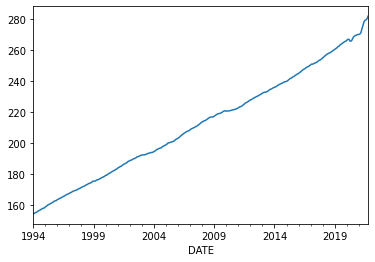

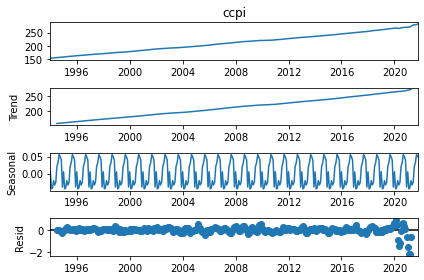

In [329]:
df_cpi['ccpi'].plot()
fig = seasonal_decompose(df_cpi['ccpi'], model='additive').plot()

The data shows a clear upward trend and is not stationary. As one of the key assumptions of the ARIMA model is that the time-series is stationary, we need to correct the non-stationarity later.

### Splitting the Data
As the dataset is small, we will use the <b>last 12 months as the out of sample test dataset</b>.

Training dataset: 322, Test dataset: 12


<AxesSubplot:xlabel='DATE'>

<AxesSubplot:xlabel='DATE'>

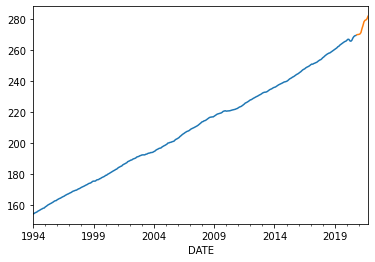

In [330]:
split_point = len(df_cpi) - 12
train, test = df_cpi[0:split_point], df_cpi[split_point:]
print('Training dataset: %d, Test dataset: %d' % (len(train), len(test)))
train['ccpi'].plot()
test['ccpi'].plot()

From the plot, we can see that 2020 showed a dip due to the pandemic restrictions. The orange line indicates the Test set.

### Take first differences
Here, we are finding the number of optimal differencing to remove unit root so that the time-series is stationary. This is done by using diff() function and testing with Augmented Dickey-Fuller test.

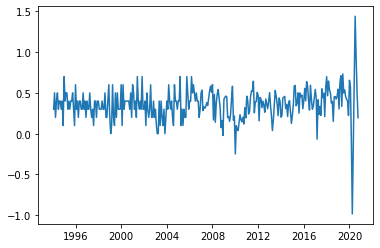

In [331]:
diff = train['ccpi'].diff()
plt.plot(diff)
plt.show()
diff = diff.dropna()

### Augmented Dickey–Fuller test
With the small p-value, a 1 differencing is enough to remove unit root and make the series stationary.

In [332]:
def adf_test(df):
    result = adfuller(df.values)
    if result[1] > 0.05:
        print("Series is not stationary")
    else:
        print("Series is stationary")

adf_test(diff)

Series is stationary


### Plot ACF and PACF
Now, we need to find the optimal p and q using acf and pacf plot. Where p is the number of lags and q is the order of the MA term. <br><br>
Finding the order of Auto Regressive Term (p)
- PACF lag 1 is significant

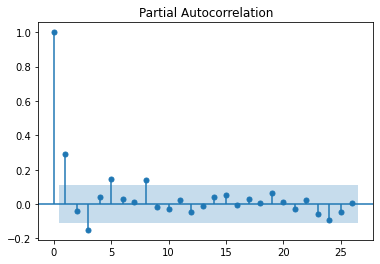

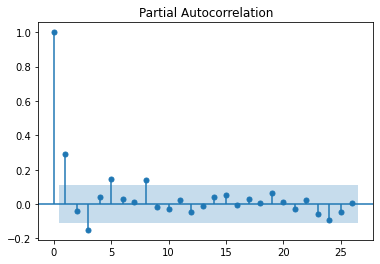

In [333]:
plot_pacf(diff.values)

Finding the order of Moving Average Term (q)<br>
- q = 1 and 2 is significant, try conservative take of q = 1.

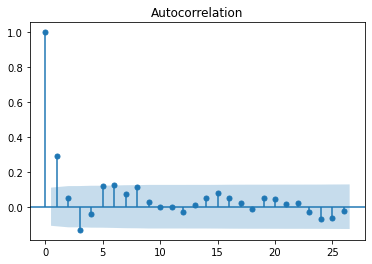

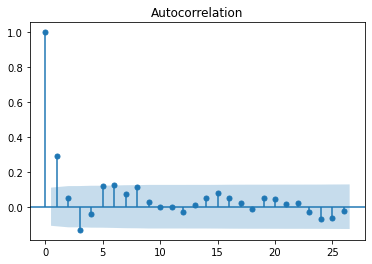

In [334]:
plot_acf(diff.values)

### Building the model
Since CPI exhibits exponential growth (variance increases), we build the model on the ln(CPI) e.g. converting the raw values to log values.<br>
As earlier discovered, the ARIMA model parameters will be set as 1,1,1.

In [335]:
arima_model = ARIMA(np.log(train['ccpi']), order = (1,1,1))

arima_fit = arima_model.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ccpi   No. Observations:                  322
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1780.484
Date:                Sun, 09 Jan 2022   AIC                          -3554.968
Time:                        06:00:58   BIC                          -3543.654
Sample:                    01-01-1994   HQIC                         -3550.450
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9682      0.016     59.833      0.000       0.937       1.000
ma.L1         -0.5010      0.043    -11.606      0.000      -0.586      -0.416
sigma2      8.851e-07   4.25e-08     20.833      0.000    8.02e-07    9.68e-07
===================================================================================
Ljung-Box (L1) (Q):                   3.44   Jarque-Bera (JB):               180.01
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.27
Prob(H) (two-sided):                  0.84   Kurtosis:                         6.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Forecast for November 2020 - October 2021
Forecast for the next 12 months (12 out-of-sample)

The forecasted U.S. Core Consumer Price Index (CPI) YoY is  1.39


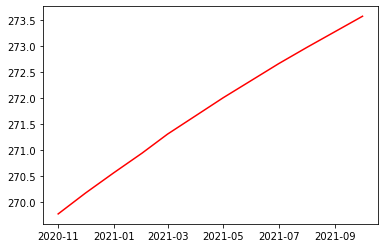

In [336]:
forecast = arima_fit.forecast(steps=12)
forecast = np.exp(forecast)

plt.plot(forecast, color = 'red')

pct_chg = ((forecast[-1] - df_cpi.iloc[-12]['ccpi'])/df_cpi.iloc[-12]['ccpi']) * 100
print('The forecasted U.S. Core Consumer Price Index (CPI) YoY is ' , round(pct_chg,2))

### Evaluating the ARIMA model
- with RMSE and
- Mean of observed y - predicted y

Based on the Mean Error, the ARIMA model overestimates the Core CPI value by an average of 0.25.

In [337]:
mse = mean_squared_error(test['ccpi'].values, forecast[:12])
print('MSE: ', mse)
model_error = test['ccpi'] - forecast
print('Mean Model Error: ', model_error.mean())

MSE:  20.43574094104357
Mean Model Error:  3.1464952666371317


### 1-Step Forecast for November 2021

In [338]:
arima_model = ARIMA(np.log(test['ccpi']), order = (1,1,1),freq=test.index.inferred_freq)

arima_fit = arima_model.fit()

forecast = arima_fit.forecast(steps=1)
forecast = np.exp(forecast)

print('The Core CPI value for the month November 2021 predicted by ARIMA model is', round(forecast[0],2))

The Core CPI value for the month November 2021 predicted by ARIMA model is 283.19


Overall, we can see that ARIMA performed badly as there was a greater increase in the later months of 2021. We can improve the model by including other features and using multivariate forecasting.


## Univariate Time Series Forecasting with LSTM
<a id = "ulstm"></a>
Long Short-Term Memory (LSTM) Recurrent Neural Network are popular in making predictions based on time series data, due to the lags of unknown duration. LSTM addresses that issue of vanishing gradient with multiple switch gates to remember longer time steps. Hence the past inputs to the model leaves a footprint. With LSTMs, there is no need to keep a finite number of states beforehand as required in the Hhidden Markov model. Common limitations (risk) of LSTM is that it is easy to overfit and hard to train in a sense that it takes alot of resources (computing power) to train these models fast, requiring memory-bandwidth-bound computation.

As the problem requires foreccasting the Core CPI value of the January 2021, we can use LSTM to predict a one-step out forecast, using 12 input time steps.

The LSTM architecture will be a simple, vanilla LSTM with one hidden layer with default activation tanh.

**References**:<br>
[The fall of RNN / LSTM](https://towardsdatascience.com/the-fall-of-rnn-lstm-2d1594c74ce0) by Eugenio Culurciello <br>
[Essentials of Deep Learning : Introduction to Long Short Term Memory](https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/)

### Scaling and Data Preparation
- Scaling with Min-Max Normalization
- Split the univariate sequence into samples with 12 steps in 1 step out 

**References**<br>
The split sequence code is based on Machine Learning Mastery's code, available [here](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/).

In [339]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(ccpi.reshape(-1,1))

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


As above, we create a data structure with 12 timesteps and 1 output.

In [340]:
n_steps_in = 12

train, test = dataset[0:310], dataset[310:len(dataset),:]

trainX, trainY = split_sequence(train, n_steps_in)
testX, testY = split_sequence(test, n_steps_in)

### Training the Model

Build vanilla model with a single layer, no dropout regularization and no Early Stopping. The number of neurons that will be used is 100, for high dimensionality (so the model can capture the trends). Most parameters are chosen through a fine-tuning and trial-and-error approach.

The number of layer, 1 is chosen because of the complexity of the problem. <br>No dropout regularization due to the simple complexity nature (there is 1 layer only, and adding dropout would cause important information to be lost) of the built neural network and dataset size. Dropout regularization at optimal levels 0.1/0.2 for LSTM were trialed and significantly decreased the performance of prediction on the test set. Dropout erase important context information, especially in this problem with limited timesteps and 1 layer. Furthermore, train loss and validation loss are carefully monitored for any overfitting.<br>
Similarly, a small learning rate of 0.001 is used due to size of the neural network and small data size.

The batch size is set as 100 epochs. Batch size fine-tuning is done based on the observation of model's peformance.


<function matplotlib.pyplot.show(close=None, block=None)>

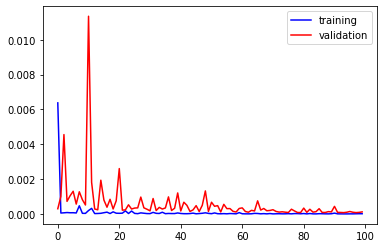

In [341]:
n_features = trainX.shape[2]

uni_model = Sequential()

# Adding the LSTM layer
uni_model.add(LSTM(64, input_shape=(trainX.shape[1], n_features)))

# Adding the output layer
uni_model.add(Dense(1))

uni_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'mean_squared_error', metrics=['mean_absolute_error'])

fit = uni_model.fit(trainX, 
          trainY, validation_data = (testX, testY),   
          epochs = 100, batch_size=1,
          verbose = 0)


# Check for overfitting
plt.plot(fit.history['loss'], label = 'training', color = 'Blue')
plt.plot(fit.history['val_loss'], label = 'validation', color = 'Red')
plt.legend()
plt.show

We can see a slight overfit.

**Note**: The validation loss shows significant spike and fluctuations due to the small batch_size passed in.

### Predictions on Test Set
- Make predictions on both the train set and test set
- Inverse transform from normalized back to the original value.

In [342]:
trainPredict = uni_model.predict(trainX)
testPredict = uni_model.predict(testX)

Ytrain_hat = scaler.inverse_transform(trainPredict)
Ytrain_actual = scaler.inverse_transform(trainY)
Ytest_hat = scaler.inverse_transform(testPredict)
Ytest_actual = scaler.inverse_transform(testY)

### Evaluating the univariate LSTM

Similar to the ARIMA, we will use MSE and Mean Model Error to evaluate the model's forecasting power.

In [343]:
trainScore = mean_squared_error(Ytrain_actual, Ytrain_hat[:,0])
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(Ytest_actual, Ytest_hat[:,0])
print('Test Score: %.2f MSE' % (testScore))

model_error = Ytest_actual - Ytest_hat[:,0]
print('Mean Model Error: ', model_error.mean())

Train Score: 0.03 MSE
Test Score: 1.97 MSE
Mean Model Error:  0.8454017944335893


This model showed significant improvement compared to ARIMA model with MSE of 1.70 and Mean Model Error of 0.78 which indicates the model gives a slight underestimation. Based on the MSE, the model has an average error of sqrt(1.70) = 1.30.



Now, we can plot the actual 2020 Core CPI against the forecasted 2020 Core CPI.

<AxesSubplot:title={'center':'Actual'}, xlabel='DATE'>

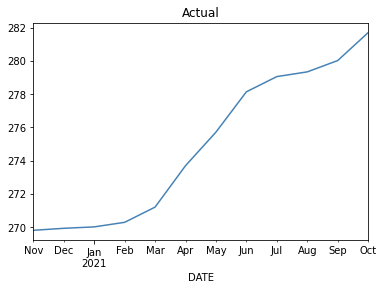

<AxesSubplot:title={'center':'Forecasted'}>

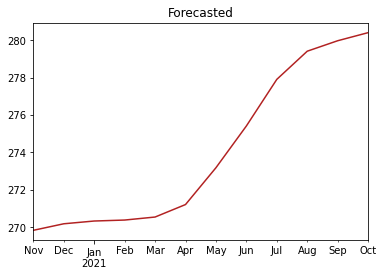

In [344]:
observed = df_cpi.loc['2020-11-01':'2021-10-01',['ccpi']]
observed.plot(color = 'SteelBlue', title = 'Actual', legend = False)
plt.show()

predicted = pd.DataFrame(Ytest_hat, index=pd.date_range('2020-11-01',periods=12,freq='M'))
predicted.plot(color = 'Firebrick', title = 'Forecasted', legend = False)
plt.show()

From the above line chart, we can see that the univariate LSTM is able to "approximate" the shape of the Core CPI (though lagging) and underestimates the value.

### Forecast for November 2021

We input the last 12 observations (12 steps in) into the model for it to forecast 1 step out which will be the Core CPI value for the month of November 2021.

Then, calculate the year-on-year percentage change manually.

In [345]:
x_input = np.array(dataset[-12:])
x_input = x_input.reshape((1, n_steps_in, n_features))

forecast_normalized = uni_model.predict(x_input)

forecast = scaler.inverse_transform(forecast_normalized)
print('The Core CPI value for the month Nov 2021 predicted by LSTM is ', forecast[0][0])

pct_chg = ((forecast[0][0] - df_cpi.iloc[-12]['ccpi'])/df_cpi.iloc[-12]['ccpi']) * 100
print('The forecasted U.S. Core Consumer Price Index (CPI) YoY is ' , round(pct_chg,2))


The Core CPI value for the month Nov 2021 predicted by LSTM is  281.54843
The forecasted U.S. Core Consumer Price Index (CPI) YoY is  4.35


## Multivariate Time Series Forecasting with LSTMs
<a id = "mlstm"></a>
### Data Preparation
- Feature Selection with Granger Causality Test
- Scaling with Min-Max normalization
- Split multivariate sequence into samples with 12 steps in and 1 step out (<i>Code referenced from machinelearningmastery</i>)


#### Feature Selection
In order to see which features is useful for forecasting core CPI, we will be using the Granger Causality test.
One of the key assumptions before using this test requires the data to be stationary. Thus, we would take the first differences for each features and use the same ADF test function to check for stationarity.

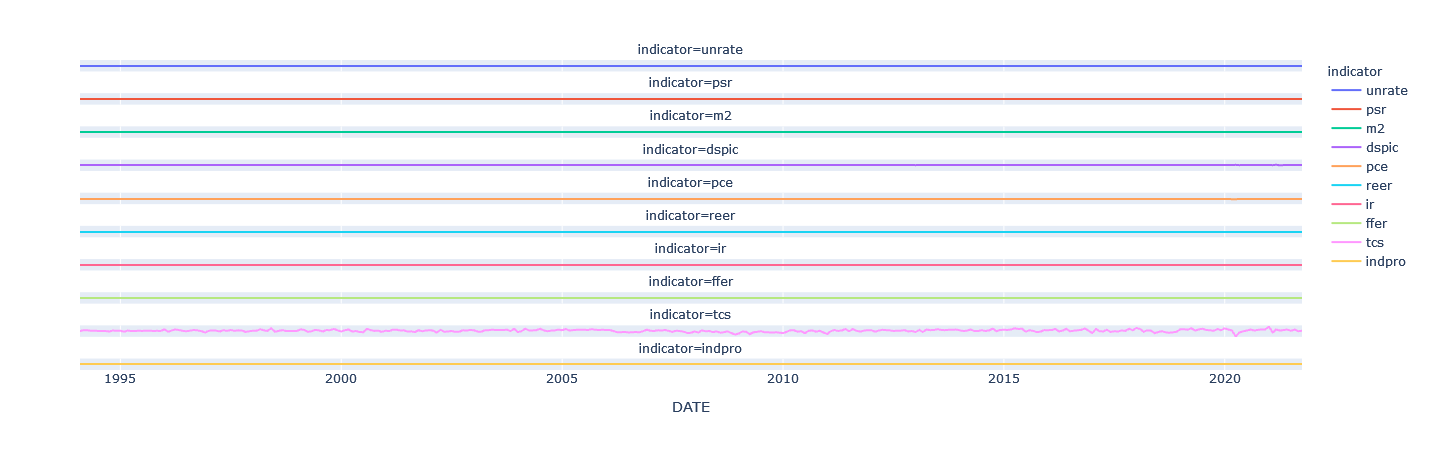

In [346]:
monthly_df_stationary = df_cpi.diff().dropna()
monthly_df_stationary = monthly_df_stationary.rename_axis('indicator', axis=1)
fig = px.line(monthly_df_stationary.iloc[:,0:10], facet_col="indicator", facet_col_wrap=1) 
fig.update_yaxes(visible=False)

In [347]:
for indi in monthly_df_stationary:
    print('ADF Test: ', indi)
    adf_test(monthly_df_stationary[[indi]])
    
monthly_df_stationary[['m2']] = monthly_df_stationary[['m2']].diff().dropna()
monthly_df_stationary[['tcs']] = monthly_df_stationary[['tcs']].diff().dropna()
monthly_df_stationary[['ccpi']] = monthly_df_stationary[['ccpi']].diff().dropna()

ADF Test:  unrate
Series is stationary
ADF Test:  psr
Series is stationary
ADF Test:  m2
Series is not stationary
ADF Test:  dspic
Series is stationary
ADF Test:  pce
Series is stationary
ADF Test:  reer
Series is stationary
ADF Test:  ir
Series is stationary
ADF Test:  ffer
Series is stationary
ADF Test:  tcs
Series is not stationary
ADF Test:  indpro
Series is stationary
ADF Test:  ccpi
Series is not stationary


After first differencing, M2, TCS and CCPI are still not stationary, so we will take the second differencing for these indicators and check if it still contains unit root.

In [348]:
# Drop any NaNs first
monthly_df_stationary = monthly_df_stationary.dropna()

for indi in monthly_df_stationary:
    print('ADF Test: ', indi)
    adf_test(monthly_df_stationary[[indi]])

ADF Test:  unrate
Series is stationary
ADF Test:  psr
Series is stationary
ADF Test:  m2
Series is stationary
ADF Test:  dspic
Series is stationary
ADF Test:  pce
Series is stationary
ADF Test:  reer
Series is stationary
ADF Test:  ir
Series is stationary
ADF Test:  ffer
Series is stationary
ADF Test:  tcs
Series is stationary
ADF Test:  indpro
Series is stationary
ADF Test:  ccpi
Series is stationary


M2, TCS and CCPI are now stationary after second differencing. We can proceed to use Grangers Causality Test to investigate causality between our features and Core CPI. Granger causality is a statistical concept of causality that is based on prediction and is highly relevant in financial economics.

The code below is taken from [stackoverflow](https://stackoverflow.com/questions/58005681/is-it-possible-to-run-a-vector-autoregression-analysis-on-a-large-gdp-data-with).

In [349]:
maxlag=12
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(monthly_df_stationary, variables = monthly_df_stationary.columns)

,unrate_x,psr_x,m2_x,dspic_x,pce_x,reer_x,ir_x,ffer_x,tcs_x,indpro_x,ccpi_x
unrate_y,1.0000,0.0018,0.0000,0.0677,0.0000,0.0011,0.0015,0.0000,0.1951,0.0000,0.0022
psr_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0277,0.0200,0.0000,0.0001,0.0000,0.0000
m2_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.0163,0.0468,0.0000,0.0275,0.0000,0.0000
dspic_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.1799,0.1497,0.0027,0.0000,0.0000,0.0000
pce_y,0.0000,0.0002,0.0000,0.0000,1.0000,0.0059,0.0218,0.0000,0.0103,0.0000,0.0005
reer_y,0.2565,0.3279,0.0335,0.2618,0.2323,1.0000,0.0601,0.5281,0.5866,0.1191,0.0266
ir_y,0.6902,0.5921,0.5635,0.5920,0.6647,0.0733,1.0000,0.3952,0.3772,0.1995,0.4451
ffer_y,0.0390,0.1214,0.3441,0.2271,0.1104,0.7364,0.0000,1.0000,0.0242,0.6030,0.7319
tcs_y,0.0019,0.0004,0.0009,0.0035,0.0000,0.0011,0.0858,0.0486,1.0000,0.0013,0.1132
indpro_y,0.0000,0.0000,0.0000,0.0002,0.0000,0.0011,0.0003,0.0000,0.0328,1.0000,0.0008


Here, we can focus on just the **last row**, and we will be using a significance level of 0.05 like earlier, hence any p-values that are less than 0.05, we can reject the null hypothesis and conclude that the feature granger causes Core CPI.<br><br> Real Effective Exchange Rate, 10Y Treasury Yield and Fed Rate are not significant, thus we can first proceed to exclude them from our future models, dropping them from the dataframe.

In [350]:
feat_df = df_cpi.drop(['reer', 'ir','ffer'], axis = 1)

#### Scaling with Min-Max Normalization

In [351]:
scaled = scaler.fit_transform(feat_df)

Convert the array back to dataframe for resuability purposes

In [352]:
scaled_df = pd.DataFrame(scaled, columns=feat_df.columns, index=feat_df.index)
scaled_df.head(5)

,unrate,psr,m2,dspic,pce,tcs,indpro,ccpi
DATE,,,,,,,,
1994-01-01,0.274336,0.157729,0.001251,0.000000,0.000000,0.000109,0.000000,0.000000
1994-02-01,0.274336,0.138801,0.000000,0.001199,0.004058,0.000000,0.001250,0.002359
1994-03-01,0.265487,0.148265,0.000978,0.003283,0.005203,0.007231,0.019393,0.006290
1994-04-01,0.256637,0.135647,0.002683,0.003309,0.007347,0.013705,0.030480,0.007862
1994-05-01,0.230088,0.173502,0.000744,0.010573,0.007210,0.017636,0.039185,0.011007


#### Splitting Multivariate Sequences into Samples

In [353]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()    
    for i in range(len(sequences)):
        #find end of pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        
        #check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        
        #gather input and output
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix - 1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

Similar to the univariate model, we will leave the last 12 months as the test set. We configure the inputs to be from 1994 to 2019 (where 2000 will contain the first 12 time steps in) for the train set and 2019 to 2020 (where 2019 will contain the first 12 steps in) for the test set.

In [354]:
#inputs
in_cpi = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['ccpi']]) 
in_ur = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['unrate']])
in_m2  = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['m2']])
in_pce = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['pce']])
in_dspic  = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['dspic']])
in_tcs = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['tcs']])
in_psr = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['psr']])
in_ind = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['indpro']])

test_cpi = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['ccpi']]) 
test_ur = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['unrate']])
test_pce = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['pce']])
test_dspic  = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['dspic']])
test_m2  = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['m2']])
test_tcs = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['tcs']])
test_psr = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['psr']])
test_ind = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['indpro']])

#output
trainoutput_cpi = in_cpi
testoutput_cpi = test_cpi

Then, we reshape the input and output data into rows, columns format.

In [355]:
in_cpi = in_cpi.reshape((len(in_cpi), 1))
in_ur = in_ur.reshape((len(in_ur), 1))
in_pce = in_pce.reshape((len(in_pce), 1))
in_dspic = in_dspic.reshape((len(in_dspic), 1))
in_m2  = in_m2.reshape((len(in_m2), 1))
in_tcs = in_tcs.reshape((len(in_tcs), 1))
in_psr = in_psr.reshape((len(in_psr), 1))
in_ind = in_ind.reshape((len(in_ind), 1))

test_cpi = test_cpi.reshape((len(test_cpi), 1))
test_ur = test_ur.reshape((len(test_ur), 1))
test_pce = test_pce.reshape((len(test_pce), 1))
test_dspic = test_dspic.reshape((len(test_dspic), 1))
test_m2  = test_m2.reshape((len(test_m2), 1))
test_tcs = test_tcs.reshape((len(test_tcs), 1))
test_psr = test_psr.reshape((len(test_psr), 1))
test_ind = test_ind.reshape((len(test_ind), 1))

trainoutput_cpi = trainoutput_cpi.reshape((len(trainoutput_cpi), 1))
testoutput_cpi = testoutput_cpi.reshape((len(testoutput_cpi), 1))

Now, we stack all the columns horizontally using numpy hstack to get it ready to be passed into the split sequences function. And pass the defined steps in and the single-step forecast.

In [356]:
trainset = np.hstack((in_cpi, in_ur, in_pce, in_dspic, in_m2, in_tcs, in_psr, in_ind, trainoutput_cpi))
testset = np.hstack((test_cpi, test_ur, test_pce, test_dspic, test_m2, test_tcs, test_psr, test_ind, testoutput_cpi))

n_steps_in = 12
n_steps_out = 1

trainX, trainy = split_sequences(trainset, n_steps_in, n_steps_out)

testX, testy = split_sequences(testset, n_steps_in, n_steps_out)

trainX.shape, trainy.shape

((300, 12, 8), (300, 1))

### Training the Model
The initial model was trialed on this multivariate with similar parameters as the univariate model but resulted in poor performance. The model was further tuned into a 500 epochs with default batch size of 32 and stacking an additional LSTM layer. A GridSearchCV attempt was done before to find the optimal epochs and batch size.

The model showed significant overfitting, thus regularization with EarlyStopping and Dropout were used. The final Dropout was set at 20% and added between the rec and Dense fully output layer. The EarlyStopping patience was set at 50.

The hyperparameters were also tuned through manual experimental runs observing the performance.

**References**:<br>
<li><a src="https://stackoverflow.com/questions/48714407/rnn-regularization-which-component-to-regularize/58868383#58868383"> A comprehensive answer to RNN Regularization

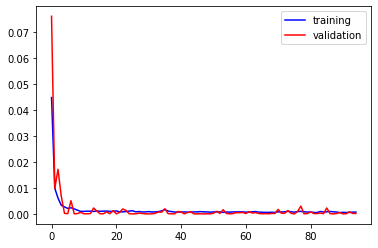

In [357]:
n_features = trainX.shape[2]

multi_model = Sequential()

# Adding the LSTM layer and dropout regularizaiton
multi_model.add(LSTM(100, return_sequences = True, input_shape=(n_steps_in, n_features)))
multi_model.add(LSTM(100))
multi_model.add(Dropout(0.2))

# Adding output layer
multi_model.add(Dense(n_steps_out))

multi_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'mean_squared_error')

earlystop = EarlyStopping(monitor = 'val_loss', patience =50,
                  mode = 'min',
                  verbose = 0)

fit = multi_model.fit(trainX, 
          trainy, validation_data = (testX, testy),   
          epochs = 500, verbose=0, callbacks = [earlystop])


# Check for overfitting
plt.plot(fit.history['loss'], label = 'training', color = 'Blue')
plt.plot(fit.history['val_loss'], label = 'validation', color = 'Red')
plt.legend()
plt.show()

**Note**: The model was early stopped close to the 170th epoch.

### Feature Importance

There are a few ways to quantify and identify feature importance that influenced the recurrent neural network. Some of which include Pertubations, [Masking](https://stackoverflow.com/questions/44119207/is-there-any-way-to-get-variable-importance-with-keras)/[LIME](https://arxiv.org/abs/1606.05386), [Permutation Importance](https://www.kaggle.com/cdeotte/lstm-feature-importance)  and [SHAP](https://christophm.github.io/interpretable-ml-book/shap.html) (however, this led to many compatibility issues with tensorflow 2.7.0 on my end).

Here, we will be using pertubation effect which is quite similar to Masking and LIME. The idea here involves introducing noise/perturbing each variable with a random normal distribution then caclulate the difference between the perturbed predicted y and original predicted y.

**References**<br>
More information on pertubation on Neural Networks available [here](https://towardsdatascience.com/perturbation-theory-in-deep-neural-network-dnn-training-adb4c20cab1b) and [here](https://stats.stackexchange.com/questions/191855/variable-importance-in-rnn-or-lstm).

In [358]:
def feature_importance(model, g):
    random_ind = np.random.choice(g.shape[0], 100, replace=False) # Randomly generate 100 numbers arange(218) 
    x = g[random_ind] #  Take 100 random sample from training set
    orig_out = model.predict(x)
    for i in range(8):  # iterate over the 7 features
        new_x = x.copy()
        perturbation_in = np.random.normal(0.0, 0.7, size=new_x.shape[:2]) # Draw random samples from normal distribution with sd = 0.7, this value is arbitary and would not affect the order of effect as its just introducing noise.
        new_x[:, :, i] = new_x[:, :, i] + perturbation_in
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
        print(f'Variable {i+1}, Perturbation Effect: {effect:.3f}')
        
feature_importance(multi_model,trainX)

Variable 1, Perturbation Effect: 0.051
Variable 2, Perturbation Effect: 0.014
Variable 3, Perturbation Effect: 0.063
Variable 4, Perturbation Effect: 0.040
Variable 5, Perturbation Effect: 0.065
Variable 6, Perturbation Effect: 0.010
Variable 7, Perturbation Effect: 0.008
Variable 8, Perturbation Effect: 0.010


With the perturbation effect results, we could say that the important features for forecasting Core CPI in this model/dataset is past **Core CPI**, **Personal Consumption Expenditure**, and **M2**. Personal Consumption is one of the most important feature and this is obvious because PCE is also an important metric in determining inflation thus it should be closely correlated with Core CPI.


### Predictions on Test Set

After prediction, we need to invert the min-max normalization. To do so, we reshape the data back to the original form before the normalization.
- Reshape the testX and concatenate with the y-hat (prediction) at the correct positions
- Reshape the testX and concatenate with the actual y at the correct positions

To match the order of the original dataframe, we concatenate in the order of unemployment_rate, m2, pce, dspic, ffr, psr and cpi.

In [360]:
testPredict = multi_model.predict(testX)

In [361]:
testX = testX.reshape((testX.shape[0], testX.shape[2]*testX.shape[1]))

In [362]:
# Invert scaling for Predicted
testY_hat = np.concatenate((testX[:, 1:8], testPredict), axis=1)
testY_hat = scaler.inverse_transform(testY_hat)

testY_hat = testY_hat[:,7]

# Invert scaling for Actual
testY_actual = np.concatenate((testX[:,1:8], testy), axis=1)
testY_actual = scaler.inverse_transform(testY_actual)

testY_actual = testY_actual[:,7]

### Evaluating the multivariate LSTM

Similar to the previous models, we will use the same metrics: MSE and Mean Model Error.

In [363]:
mse = mean_squared_error(testY_actual, testY_hat)
print('Test MSE: %.3f' % mse)

model_error = testY_actual - testY_hat
print('Mean Model Error: ', model_error.mean())

Test MSE: 2.984
Mean Model Error:  1.5547430760115237


<AxesSubplot:title={'center':'Actual'}, xlabel='DATE'>

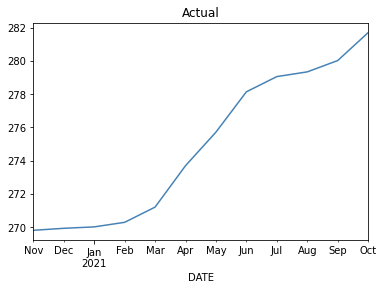

<AxesSubplot:title={'center':'Forecasted'}>

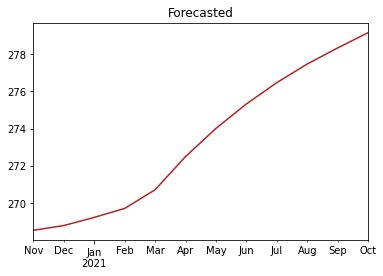

In [364]:
observed = df_cpi.loc['2020-11-01':'2021-10-01',['ccpi']]
observed.plot(color = 'SteelBlue', title = 'Actual', legend = False)
plt.show()

predicted = pd.DataFrame(testY_hat, index=pd.date_range('2020-11-01',periods=12,freq='M'))
predicted.plot(color = 'Firebrick', title = 'Forecasted', legend = False)
plt.show()

As compared to the univariate LSTM, the model had a bad start in January was unable to 'approximate' the actual shape of the Core CPI in 2020.

### Forecast for November 2021

In [365]:
x_input = np.array(scaled[-12:])
x_input = x_input.reshape((1, n_steps_in, n_features))

forecast_normalized = multi_model.predict(x_input)

# Manually inverse Min-max normalization
max_cpi = df_cpi['ccpi'].max()
min_cpi = df_cpi['ccpi'].min()
forecast =  max_cpi-forecast_normalized[0][0]/(max_cpi-min_cpi)
print('The Core CPI value for the month Nov 2021 predicted by LSTM is ', forecast)

pct_chg = ((forecast - df_cpi.iloc[-12]['ccpi'])/df_cpi.iloc[-12]['ccpi']) * 100
print('The forecasted U.S. Core Consumer Price Index (CPI) YoY is ' , round(pct_chg,2))

The Core CPI value for the month Nov 2021 predicted by LSTM is  281.6889910078429
The forecasted U.S. Core Consumer Price Index (CPI) YoY is  4.4
